# PGP AI - AI and Machine Learning Capstone Project

DESCRIPTION

Problem Statement

Amazon is an online shopping website that now caters to millions of people everywhere. Over 34,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 
The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.
You are required to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

In [1]:
import numpy as np
import pandas as pd

import re
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def load_data(path=""):
    return pd.read_csv(path)

In [3]:
def merge_data(datasets=[]):
    return pd.concat(datasets)

In [4]:
def sample_data(data, row_count=5):
    return data[:row_count]

In [5]:
def preprocess(data):
    data = [regexp_tokenize(record, pattern='[A-Za-z]\w+') 
                   for record in data]
    print("Completed Word Tokenization")

    data = [[word for word in text 
                    if word not in stopwords.words('english')] 
                   for text in data]
    print("Completed Removal of nltk StopWords")

    data = [[word for word in text 
                    if len(word) > 1] 
                   for text in data]
    print("Completed Removal of Words of length = 1")
    
    data = [[WordNetLemmatizer().lemmatize(word) for word in text] 
                   for text in data]
    print("Completed Lemmatization of Words")


    data_cleaned = []

    for record in data:
        sent = ""
        for word in record:
            sent = sent + word + " "
        data_cleaned.append(sent[:-1])

    print("Completed Joining of the cleaned Text into a record")
    
    print("Analysing Tokens:")
    token_analysis(data)
    
    return data_cleaned

In [6]:
def token_analysis(data):
    terms = []

    for record in data:
        for word in record:
            terms.append(word)

    print("Total Tokens: {}".format(len(terms)))

    from collections import Counter

    counts_terms = Counter(terms)
    terms_df = pd.DataFrame(counts_terms.most_common(10), 
                            columns=['term', 'count'])
    terms_df

    terms_df.sort_values(by='count', 
                         ascending=True).plot(kind="barh", 
                                              x='term', 
                                              figsize=(12,10), 
                                              color='teal')
    plt.style.use('seaborn')
    plt.show()

In [7]:
def create_dataset(data, features, label, vectorizer):
    X = vectorizer.fit_transform(data[features].tolist())
    y = data[label].tolist()
    return X, y

In [8]:
def resample_dataset(X, y, sampler):
    return sampler.fit_sample(X, y)

In [9]:
def create_train_test_datasets(X, y):
    from sklearn.model_selection import train_test_split

    return train_test_split(X, y, test_size=0.3, random_state = 42)

In [10]:
def create_model(X, y, model):
    return model.fit(X, y)

In [11]:
def assess_model_score(model, X_test, y_test):
    scores = dict()
    y_pred = model.predict(X_test)
    scores['F1Score'] = f1_score(y_test, y_pred, average='weighted')
    scores['Accuracy'] = accuracy_score(y_test, y_pred)
    scores['Precision'] = precision_score(y_test, y_pred, average='weighted')
    scores['Recall'] = recall_score(y_test, y_pred, average='weighted')
    #scores['ROC_AUC_Score'] = roc_auc_score(y_test, model.predict(X_test), average='weighted', multi_class ='ovr')
    
    return scores

### Week 1:
1. Perform an EDA on the dataset.
    a. See what a positive, negative, and neutral review looks like
    b. Check the class count for each class. It’s a class imbalance problem.
2. Convert the reviews in Tf-Idf score.
3. Run multinomial Naive Bayes classifier. Everything will be classified as positive because of the class imbalance.

#### Loading Datasets

In [12]:
train_df = load_data("datasets/train_data.csv")
test_data_hidden_df = load_data("datasets/test_data_hidden.csv")
test_df = load_data("datasets/test_data.csv")

#### Describing the Datasets

In [13]:
print("Train:")
train_df.info()
print("\nTest Data Hidden:")
test_data_hidden_df.info()
print("\nTest:")
test_df.info()

Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               4000 non-null   object
 1   brand              4000 non-null   object
 2   categories         4000 non-null   object
 3   primaryCategories  4000 non-null   object
 4   reviews.date       4000 non-null   object
 5   reviews.text       4000 non-null   object
 6   reviews.title      3990 non-null   object
 7   sentiment          4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB

Test Data Hidden:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCate

#### Observation:
1. There are 4000 training samples and 1000 Test Samples
2. The files are separated into training and test datasets
3. For the Training we need to merge the training and test_data_hidden csv files
4. For testing we need to create a fourth file from test_data and test_data_hidden

In [14]:
merge_df = merge_data([train_df,test_data_hidden_df])

In [15]:
sample_data(merge_df,10)

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive
5,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-12-23T00:00:00.000Z,This is a great product. Light weight. I wish ...,You will love it,Positive
6,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-05-31T00:00:00.000Z,My 7-year old daughter saved up to by this. He...,OK For Entry Level Tablet,Neutral
7,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-06-05T00:00:00.000Z,Purchased this for my son. Has room to upgrade...,Great for kids or smaller needs,Positive
8,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-11-23T00:00:00.000Z,Bought this for my mom and it was just what sh...,Great tablet,Positive
9,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-05-18T00:00:00.000Z,"was cheap, can not run chrome stuff, returned ...","was cheap, can not run chrome stuff, returned",Negative


In [16]:
merge_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,5000,5000,5000,5000,5000,5000,4987,5000
unique,23,1,23,4,679,4385,3124,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,A little more complicated than my original kin...,Great tablet,Positive
freq,845,5000,797,3276,125,4,122,4686


In [17]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               5000 non-null   object
 1   brand              5000 non-null   object
 2   categories         5000 non-null   object
 3   primaryCategories  5000 non-null   object
 4   reviews.date       5000 non-null   object
 5   reviews.text       5000 non-null   object
 6   reviews.title      4987 non-null   object
 7   sentiment          5000 non-null   object
dtypes: object(8)
memory usage: 351.6+ KB


### Observations:
- Total Records: 5000
- Data Column for building model: reviews.text
- Label Column for identifying class: sentiment
- Unique Reviews: 4385
- Number of Output Class: 3
- __No Null Values for the feature column reviews.text.__

### Analysing the output class distribution in the datasets

Positive    4686
Neutral      197
Negative     117
Name: sentiment, dtype: int64


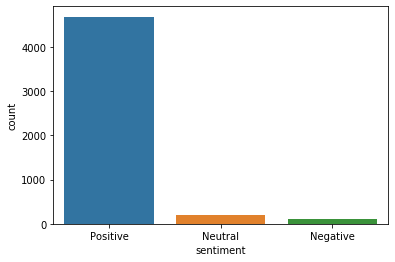

In [18]:
print(merge_df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=merge_df)
plt.show()

### Observations:
> __There is a class imbalance present as `Positive` cases are mostly represented.__

### Data Preprocessing and Cleaning to bring out the context of the sentiments: 
1. __Word Tokenization:__ Extracting words from each reviews.text column
2. __Removal of Stopwords:__ Removing words like `a`, `an`, `the` which are insignificant to sentiment features.
3. __Removal of single character word:__ Single character words donot convey meaning in a sentiment.
4. __Lemmatization:__ Lemmatize and stem both generate the root form of the word except stem may generate a word that doesn’t exist in the dictionary. Lemmatization is used more widely than stemming and also for this project we considering lemmatization.

Completed Word Tokenization
Completed Removal of nltk StopWords
Completed Removal of Words of length = 1
Completed Lemmatization of Words
Completed Joining of the cleaned Text into a record
Analysing Tokens:
Total Tokens: 82161


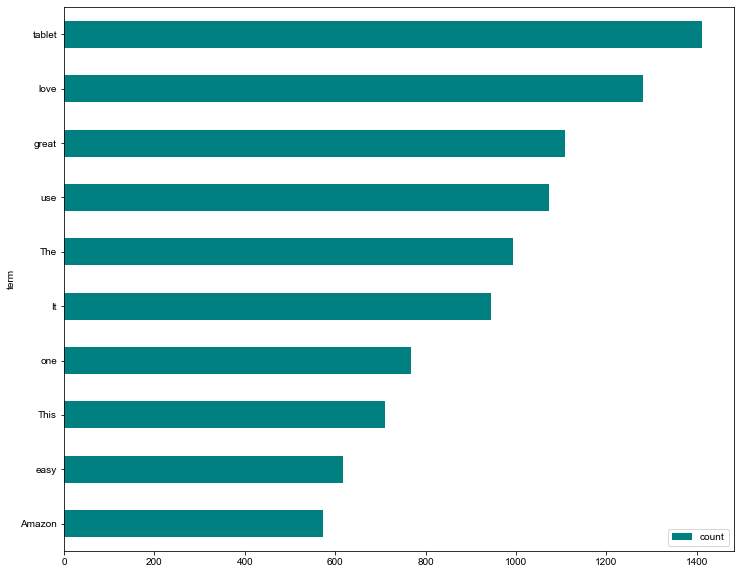

Wall time: 29.1 s


In [19]:
%%time
merge_df['reviews_cleaned'] = preprocess(merge_df['reviews.text'].tolist())

#### Results after preprocessing

In [21]:
merge_df[['reviews.text','reviews_cleaned']][:5]

,reviews.text,reviews_cleaned
0,Purchased on Black FridayPros - Great Price (e...,Purchased Black FridayPros Great Price even sa...
1,I purchased two Amazon in Echo Plus and two do...,purchased two Amazon Echo Plus two dot plus fo...
2,Just an average Alexa option. Does show a few ...,Just average Alexa option Does show thing scre...
3,"very good product. Exactly what I wanted, and ...",good product Exactly wanted good price
4,This is the 3rd one I've purchased. I've bough...,This rd one purchased bought one niece No case...


#### Creating a Training dataset
> 1. For this project, we are using `TfidfVectorizer` to transform the text reviews in numerical form. Other alternatives that can used are CountVectorizer, etc.
>
> 2. The max_features parameter for the vectorizer is set to __2000__, which will generate a sparse matix of 2000 feature columns of the sentiment text.

#### Preparing X_train and y_train for training

In [22]:
X_train, y_train = create_dataset(merge_df, 'reviews_cleaned', 'sentiment', TfidfVectorizer(max_features=2000))

In [23]:
print(X_train.shape)
print(len(y_train))

(5000, 2000)
5000


#### Creating a Test Dataset

In [24]:
validation_df = test_df.copy()
validation_df.insert(7, 'sentiment', test_data_hidden_df['sentiment'])

In [25]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCategories  1000 non-null   object
 4   reviews.date       1000 non-null   object
 5   reviews.text       1000 non-null   object
 6   reviews.title      997 non-null    object
 7   sentiment          1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


### Preprocessing Test Dataset for predictions

Completed Word Tokenization
Completed Removal of nltk StopWords
Completed Removal of Words of length = 1
Completed Lemmatization of Words
Completed Joining of the cleaned Text into a record
Analysing Tokens:
Total Tokens: 17104


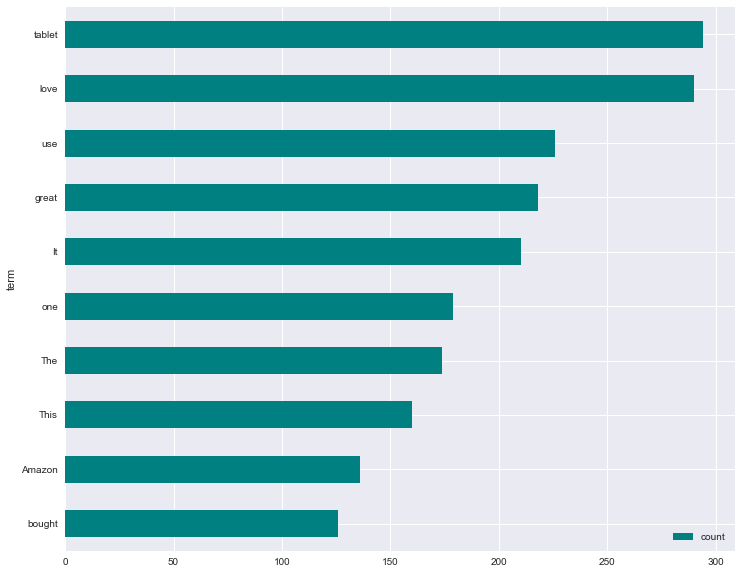

Wall time: 5.99 s


In [26]:
%%time
validation_df['reviews_cleaned'] = preprocess(validation_df['reviews.text'].tolist())

Positive    937
Neutral      39
Negative     24
Name: sentiment, dtype: int64


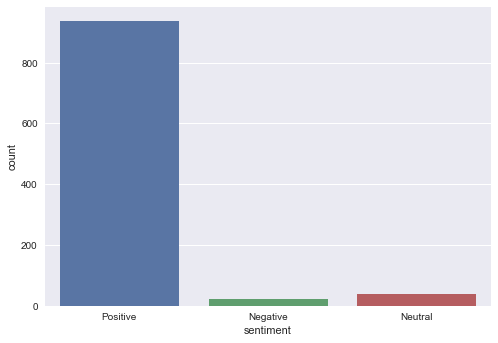

In [27]:
print(validation_df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=validation_df)
plt.show()

#### Preparing X_test and y_test for evaluating the prepared models

In [ ]:
X_test, y_test = create_dataset(validation_df, 'reviews_cleaned', 'sentiment', TfidfVectorizer(max_features=2000))

In [ ]:
print(X_test.shape)
print(len(y_test))

#### Modeling a Multinomial Nayve Bayes Classifier over the training samples

In [ ]:
multi_nb = create_model(X_train, y_train, MultinomialNB())

In [ ]:
print(classification_report(y_test, multi_nb.predict(X_test), digits=4))

#### Observations on Multinomial Nayve Bayes Classifier over given training samples
> Because of class imbalance problem all are predicted as positive


### Week 2:
1. Oversampling or undersampling can be used to tackle the class imbalance problem.
2. In case of class imbalance criteria, use the following metrices for evaluating model performance: precision, recall, F1-score, AUCROC curve. Use F1-Score as the evaluation criteria for this project.
3. Use Tree-based classifiers like Random Forest and XGBoost.

> __Note:__ Tree-based classifiers work on two ideologies namely, Bagging or Boosting and have fine-tuning parameter which takes care of the imbalanced class.

Over Sampling and Under Sampling is done through imalanced-learn package execute the below command to setup.
> `pip install imbalanced-learn`

#### Over Sampled Training Data

In [ ]:
X_train_os, y_train_os = resample_dataset(X_train, y_train, RandomOverSampler())
print(X_train_os.shape)

print(pd.DataFrame(y_train_os)[0].value_counts())
plt.style.use('seaborn')
pd.DataFrame(y_train_os)[0].value_counts().plot(kind='bar', title='Over Sampled Training Data')
plt.show()

#### Over Sampled Test Data

In [ ]:
X_test_os, y_test_os = resample_dataset(X_test, y_test, RandomOverSampler())
print(X_test_os.shape)

print(pd.DataFrame(y_test_os)[0].value_counts())
plt.style.use('seaborn')
pd.DataFrame(y_test_os)[0].value_counts().plot(kind='bar', title='Over Sampled Test Data')
plt.show()

#### Under Sampled Training Data

In [ ]:
X_train_us, y_train_us = resample_dataset(X_train, y_train, RandomUnderSampler())
print(X_train_us.shape)

print(pd.DataFrame(y_train_us)[0].value_counts())
plt.style.use('seaborn')
pd.DataFrame(y_train_us)[0].value_counts().plot(kind='bar', title='Under Sampled Training Data')
plt.show()

#### Under Sampled Test Data

In [ ]:
X_test_us, y_test_us = resample_dataset(X_test, y_test, RandomUnderSampler())
print(X_test_us.shape)

print(pd.DataFrame(y_test_us)[0].value_counts())
plt.style.use('seaborn')
pd.DataFrame(y_test_us)[0].value_counts().plot(kind='bar', title='Under Sampled Test Data')
plt.show()

___Creating model and sample collections to compare the sampling strategy with F1 Score___

In [ ]:
models = {
            'multinomial_nb': MultinomialNB(),
            'random_forest': RandomForestClassifier(),
            'XGBClassifer': XGBClassifier()
         }

samples = {
            'unsampled': [X_train, y_train, X_test, y_test],
            'over_sampled': [X_train_os, y_train_os, X_test_os, y_test_os],
            'under_sampled': [X_train_us, y_train_us, X_test_us, y_test_us]
        }

In [ ]:
def create_models(models, samples):
    scores = dict()
    for model_name, model in models.items():
        for label, sample in samples.items():
            scores[model_name+'-'+label] = assess_model_score(create_model(sample[0], sample[1], model), sample[2], sample[3])
    return scores        

In [ ]:
%%time
scores = pd.DataFrame(create_models(models, samples)).transpose()

In [ ]:
scores

In [ ]:
scores.plot(kind='bar', title='Metrics Scores', figsize=(20,6))
plt.show()

### Week 3:
1. Apply multi-class SVM’s and neural nets.
2. Use possible ensemble techniques like: XGboost + oversampled_multinomial_NB.
3. Assign a score to the sentence sentiment (engineer a feature called sentiment score). Use this engineered feature in the model and check for improvements. Draw insights on the same.

In [ ]:
svm_kernels = {
    'linear': {
        'kernel':'linear', 
        'C':1, 
        'decision_function_shape':'ovo'
    },
    'rbf': {
        'kernel':'rbf', 
        'C':1,
        'gamma':1,
        'decision_function_shape':'ovo'
    },
    'poly': {
        'kernel':'poly', 
        'C':1,
        'degree':3,
        'decision_function_shape':'ovo'
    },
    'sigmoid': {
        'kernel':'sigmoid', 
        'C':1, 
        'decision_function_shape':'ovo'
    }
}
def assess_svm_kernels(samples):
    svm_scores = dict()
    for label, sample in samples.items():
        for model_name, params in svm_kernels.items():
            model = SVC().set_params(**params).fit(sample[0], sample[1])
            svm_scores[model_name+'-'+label] = assess_model_score(model, sample[2], sample[3])
    return svm_scores

In [ ]:
%%time
svm_scores = pd.DataFrame(assess_svm_kernels(samples)).transpose()

In [ ]:
svm_scores

In [ ]:
svm_scores.plot(kind='bar', title='Metrics Scores for SVM', figsize=(15,6))
plt.show()

#### Adding Sentiment Score using VADER
> __VADER__ ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.
>
> VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.
For example- Words like ___‘love’, ‘enjoy’, ‘happy’, ‘like’___ all convey a positive sentiment. Also VADER is intelligent enough to understand the basic context of these words, such as “did not love” as a negative statement. It also understands the emphasis of capitalization and punctuation, such as ___“ENJOY”___

In [ ]:
# import nltk
# nltk.download('vader_lexicon')

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

___Some Examples of VADER Sentiment Inensity Analyzer___

In [ ]:
a = 'This was a good movie.'
print(sid.polarity_scores(a))

b = 'This was the best, most awesome movie EVER MADE!!!'
print(sid.polarity_scores(b))

___Adding Sentiment instenity Compound Score as a feature in our training and test datasets___

#### Training Dataset:

In [ ]:
merge_score_df['sentiment_scores'] = merge_df['reviews.text'].apply(lambda review: 
                                                             sid.polarity_scores(review))
merge_score_df['sentiment_compound_score'] = merge_score_df['sentiment_scores'].apply(lambda score_dict: 
                                                               score_dict['compound'])
merge_score_df.head()

#### Test dataset:

In [ ]:
validation_score_df['sentiment_scores'] = validation_df['reviews.text'].apply(lambda review: 
                                                             sid.polarity_scores(review))
validation_score_df['sentiment_compound_score'] = validation_score_df['sentiment_scores'].apply(lambda score_dict: 
                                                               score_dict['compound'])
validation_score_df.head()